In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
from datetime import date
today = date.today()
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import string
from sklearn.model_selection import GridSearchCV
from itertools import combinations

### Fonction de préprocessing
* RemoveStopWord : Supression des mots qui sont dans les Stop Word English
* Lemmatisation : Fonction qui trouve la racine des mots
* RemoveTop100 : Fonction qui supprime les mots qui ne sont pas dans le TOP 100 (Utilisé pour les Tags)

In [20]:
#Fonction de preprocessing
stop_words = set(stopwords.words('English'))
def removeStopWord(Word_list):
    filtered_Word_list = Word_list[:] #make a copy of the Word_list
    for Word in Word_list: # iterate over Word_list
        if Word.lower() in stop_words: 
            filtered_Word_list.remove(Word) # remove Word from filtered_Word_list if it is a stopword
    return filtered_Word_list

# Instantiate stemmers
porter = PorterStemmer()
#Fonction de lemmatisation
def lemmatisation(Word_list):
    Words = Word_list[:] #make a copy of the Word_list
    Words = [porter.stem(word) for word in Words]
    return Words

#Fonction qui supprime le tag si celui ci n'appartient au TOP        
def removeNotTop100(Word_list):
    filtered_Word_list = Word_list[:] #make a copy of the Word_list
    for Word in Word_list: # iterate over Word_list
        if Word not in Top100: 
            filtered_Word_list.remove(Word) # remove Word from filtered_Word_list if it is a stopword
    if len(filtered_Word_list) == 0:
        return None
    else:
        return filtered_Word_list
    
#Fonction qui traite le C#
def processCSharp(Word_list):
    word_list = Word_list[:] #make a copy of the Word_list
    for index, value in enumerate(word_list):
        if value == '#':
            word_list.remove(value) # remove Word from filtered_Word_list if it is a stopword
            word_list[index-1] = 'c#'
    return word_list

In [21]:
#Lecture du Fichier
df = pd.read_csv('QueryResults.csv', sep = ',', encoding='UTF-8')

#Lecture du Fichier de tags
#df_tags1 = pd.read_csv('Tags1.csv', sep = ',', encoding='UTF-8')
#df_tags2 = pd.read_csv('Tags2.csv', sep = ',', encoding='UTF-8')

#df_tags_full = pd.concat([df_tags1, df_tags2], axis=0)



In [ ]:
print(df.shape)
print(df.head(5))

In [ ]:
df.info()

In [35]:
df.isna().mean()

Id                       0.0
BODY                     0.0
Title                    0.0
Tags                     0.0
CreationDate             0.0
TitleBody                0.0
processed_tags_final     0.0
processed_body_final     0.0
processed_title_final    0.0
tags_words               0.0
dtype: float64

In [ ]:
#Téléchargement des packages nltk
nltk.download()

## Mise en minuscule

In [22]:
df["BODY"] = df["BODY"].str.lower()
df["Tags"] = df["Tags"].str.lower()
df["Title"] = df["Title"].str.lower()

In [23]:
df["TitleBody"] = df["Title"] + " " + df["BODY"]

# Traitement du champs Tags
* On détermine les 100 Tags les plus utlisés
* On supprime tous les Tags qui ne font pas partis de ce TOP 100
* Supression des lignes Tags

## Première méthode avec le CountVectorizer (Sac de Mots)

In [ ]:
# Processing tags
df["Tags1"] = df["Tags"].replace({"<" : " "},
                                     regex=True)
df["Tags1"] = df["Tags1"].replace({">" : ","},
                                     regex=True)
df["Tags1"] = df["Tags1"].str.rstrip(',')

In [ ]:
vectorizer = CountVectorizer(max_features=100)
bow_tags = vectorizer.fit_transform(df["Tags1"]).toarray()
df_tags = pd.DataFrame(bow_tags, columns=vectorizer.get_feature_names_out())
df_tags = pd.DataFrame(df_tags.sum(), columns=["Value"])

In [ ]:
top_20_tags_word = df_tags.sort_values("Value", ascending=False)[:30]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_tags_word.index, width=top_20_tags_word.Value)
plt.title("Histogramme des 20 tags les plus représentés (Bag-Of-Words)")
plt.show()

In [ ]:
tags_more_frequent = df_tags.loc[df_tags["Value"] >= 150].sort_values("Value", ascending=False).index.tolist()

In [ ]:
tags_only = df["Tags1"].str.split(",", expand=True)
df = pd.merge(df, tags_only,left_index=True,right_index=True)
df.columns = ["Id", "Title", "Body", "Tags","CreationDate","Tags1" ,"Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"]

In [ ]:
tags = ["Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"]

for i in tags_more_frequent:
    for j in tags:
        more_frequent = df.loc[df[j].str.contains(i, na=True)]
        
more_frequent.drop(["Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"], axis=1, inplace=True)

## Deuxième méthode avec le TOKENIZER et l'expression régulière

In [32]:
#Expression régulière pour prendre uniquement les valeurs entre <>
tokenizer = RegexpTokenizer('(?<=\<).*?(?=\>)')

#Création de la colonne avec ces valeurs
df['tags_words'] = df.apply(lambda row: tokenizer.tokenize(row['Tags']), axis=1)

#Comptage de l'utlisation des mots
Top_Word = nltk.FreqDist()
Top100 = []
for x in df['tags_words']:
    Top_Word += nltk.FreqDist(x)

for i in Top_Word.most_common()[0:100]:
    Top100.append(i[0])
    
#Suppression des Tags qui ne sont pas dans le TOP
df['processed_tags_final'] = df.apply(lambda row:removeNotTop100(row['tags_words']), axis=1)

In [26]:
#Suppression des lignes sans Tags
df = df.dropna()

## Affichage d'un WORDCLOUD sur la feature TAGS

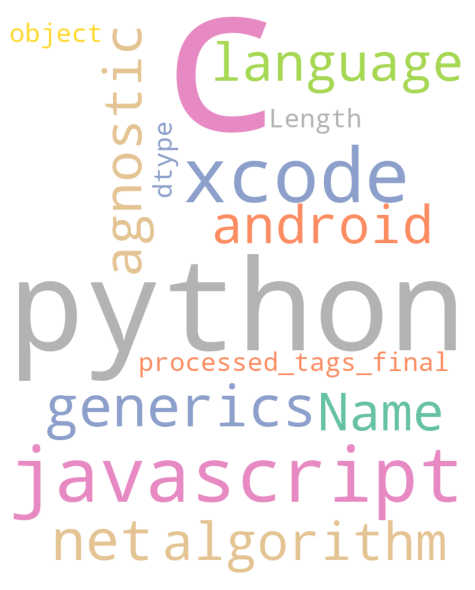

In [36]:
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['processed_tags_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Préprocesing du champs BODY
* Utilisation de BEAUTIFULSOUP pour le traitement HTML
* Puis remplacement des retours chariots et des :
* Création du nuage de mots
* Supression des StopWord Anglais

In [27]:
#Préprocessing du champ BODY
df['processed_body'] = df['BODY'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
df['processed_body'] = df['processed_body'].map(lambda x: x.replace('\n', ' '))
df['processed_body'] = df['processed_body'].map(lambda x: x.replace(':', ''))

punct = string.punctuation
for c in punct:
    if c != '#':
        df['processed_body'] = df['processed_body'].map(lambda x: x.replace(c, ''))

#Création des nuages de mots avec NLTK
df['processed_body2'] = df.apply(lambda row: nltk.word_tokenize(row['processed_body'],language='english'), axis=1)

#Supression des StopWord
df['processed_body_final'] = df.apply(lambda row:removeStopWord(row['processed_body2']), axis=1)

#Lemmatisation
#df['processed_body_final'] = df.apply(lambda row:lemmatisation(row['processed_body_final']), axis=1)

### Création d'un nuage de mots pour le BODY

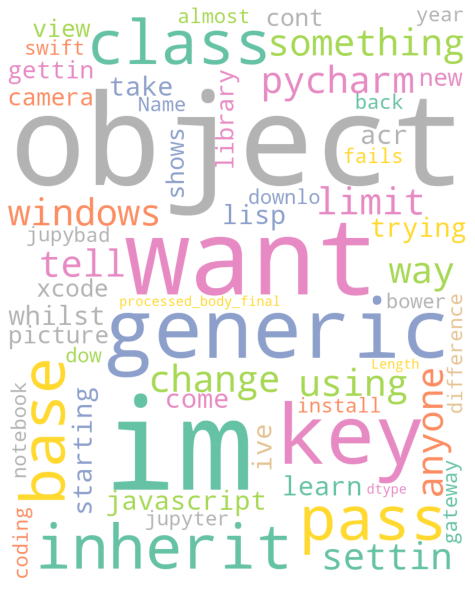

In [37]:
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['processed_body_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Préprocesing du champs Titre

* Remplacement des retours chariots et des :
* Création du nuage de mots
* Supression des StopWord Anglais

In [28]:
#Préprocessing du champ Title
df['processed_title'] = df['Title'].map(lambda x: x.replace('\n', ' '))

punct = string.punctuation
for c in punct:
    if c != '#':
        df['processed_title'] = df['processed_title'].map(lambda x: x.replace(c, ''))

df['processed_title'] = df['processed_title'].map(lambda x: x.replace(':', ''))

#Création des nuages de mots avec NLTK
df['processed_title2'] = df.apply(lambda row: nltk.word_tokenize(row['processed_title']), axis=1)

#Supression des StopWord
df['processed_title_final'] = df.apply(lambda row:removeStopWord(row['processed_title2']), axis=1)

#Lemmatisation
#df['processed_title_final'] = df.apply(lambda row:lemmatisation(row['processed_title_final']), axis=1)

#Traitement du C#
df['processed_title_final'] = df.apply(lambda row:processCSharp(row['processed_title_final']), axis=1)

In [29]:
#Suppression des colonnes inutiles
df.drop({'processed_body','processed_body2','tags_words','processed_title','processed_title2'}, axis=1, inplace=True)

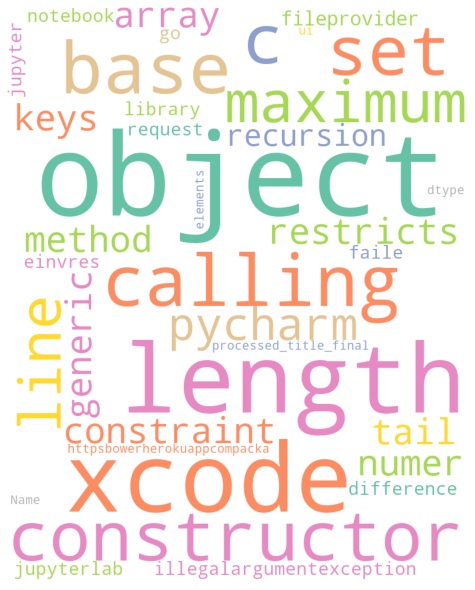

In [38]:
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['processed_title_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [39]:
df.head(10)

,Id,BODY,Title,Tags,CreationDate,TitleBody,processed_tags_final,processed_body_final,processed_title_final,tags_words
0,12051,<p>if i inherit from a base class and want to ...,calling the base constructor in c#,<c#><.net><inheritance><constructor>,2008-08-15 07:39:23,calling the base constructor in c# <p>if i inh...,"[c#, .net]","[inherit, base, class, want, pass, something, ...","[calling, base, constructor, c#]","[c#, .net, inheritance, constructor]"
1,17319422,<p>i am using pycharm on windows and want to c...,how do i set the maximum line length in pycharm?,<python><pycharm><pep8>,2013-06-26 12:00:31,how do i set the maximum line length in pychar...,[python],"[using, pycharm, windows, want, change, settin...","[set, maximum, line, length, pycharm]","[python, pycharm, pep8]"
2,32664,<p>can anyone tell me if there is a way with g...,is there a constraint that restricts my generi...,<c#><generics><constraints>,2008-08-28 16:04:49,is there a constraint that restricts my generi...,"[c#, generics]","[anyone, tell, way, generics, limit, generic, ...","[constraint, restricts, generic, method, numer...","[c#, generics, constraints]"
3,8763125,<p>i would like to get the keys of a javascrip...,get array of object's keys,<javascript><ecmascript-5>,2012-01-06 19:12:38,get array of object's keys <p>i would like to ...,[javascript],"[would, like, get, keys, javascript, object, a...","[get, array, objects, keys]","[javascript, ecmascript-5]"
5,33923,"<p>whilst starting to learn lisp, i've come ac...",what is tail recursion?,<algorithm><language-agnostic><functional-prog...,2008-08-29 03:48:03,what is tail recursion? <p>whilst starting to ...,"[algorithm, language-agnostic]","[whilst, starting, learn, lisp, ive, come, acr...","[tail, recursion]","[algorithm, language-agnostic, functional-prog..."
6,33969,<p>we're experimenting with various ways to th...,best way to implement request throttling in as...,<asp.net-mvc><throttling>,2008-08-29 04:50:50,best way to implement request throttling in as...,[asp.net-mvc],"[experimenting, various, ways, throttle, user,...","[best, way, implement, request, throttling, as...","[asp.net-mvc, throttling]"
7,33978,<p>how would you go about finding out how much...,find out how much memory is being used by an o...,<python><performance><memory-profiling>,2008-08-29 04:59:31,find out how much memory is being used by an o...,"[python, performance]","[would, go, finding, much, memory, used, objec...","[find, much, memory, used, object, python]","[python, performance, memory-profiling]"
8,33207,<p>what frameworks exist to unit test objectiv...,what is the best way to unit test objective-c ...,<objective-c><cocoa><unit-testing><xcode>,2008-08-28 19:41:30,what is the best way to unit test objective-c ...,"[objective-c, unit-testing, xcode]","[frameworks, exist, unit, test, objectivec, co...","[best, way, unit, test, objectivec, code]","[objective-c, cocoa, unit-testing, xcode]"
9,32899,<p>i have some kind of test data and want to c...,how do you generate dynamic (parameterized) un...,<python><unit-testing><parameterized-unit-test>,2008-08-28 17:49:02,how do you generate dynamic (parameterized) un...,"[python, unit-testing]","[kind, test, data, want, create, unit, test, i...","[generate, dynamic, parameterized, unit, tests...","[python, unit-testing, parameterized-unit-test]"
10,33746,<p>at work we are being asked to create xml fi...,xml attribute vs xml element,<xml><xsd>,2008-08-29 01:15:52,xml attribute vs xml element <p>at work we are...,[xml],"[work, asked, create, xml, files, pass, data, ...","[xml, attribute, vs, xml, element]","[xml, xsd]"


In [31]:
df.to_csv('posts_after_prepocessing.csv', index=False)

In [34]:
import pickle
pickle.dump(df, open('df_afterPreprocessing.pickle', 'wb')) #Saving DF